# VGG16

In this notebook, I'm using transfer learning with the VGG16 network to compare its performance to CNN1 which I built and trained on the PCam dataset. 

The advantage of using transfer learning is that we can take extremely deep CNN architectures which have been pretrained on image data, and leverage their predictive power without investing the time and computing power necessary to train the networks ourselves. By "freezing" the pretrained layers and adding a small number of trainable, fully connected layers onto the output of the network, we can adapt these networks to make predictions on arbitrary image data by training only a small fraction of the total available parameters.

## 1.1 Google Colab Setup - When running locally, skip ahead to Local Setup

I ran this notebook in Google Colab Pro in the Python3 environment using a GPU runtime.

At the time of writing, it was necessary to update the `tensorflow_datasets` package to import the dataset correctly. After running this cell, restart the runtime so that the new version of this package is loaded.

In [ ]:
!pip install tensorflow_datasets==4.2.0

The following cells have been adapted from code located [here](https://towardsdatascience.com/google-drive-google-colab-github-dont-just-read-do-it-5554d5824228)

Ensure we're connected to a GPU

In [ ]:
from tensorflow.test import gpu_device_name

device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Mount Google Drive

In [ ]:
from google.colab import drive 

# Default location for the drive
ROOT = "/content/drive"  
# Print content of ROOT
print(ROOT)                 

# Mount Google Drive at /content/drive
drive.mount(ROOT)           

Change to the directory containing project files

In [ ]:
PROJECT_PATH = '/content/drive/MyDrive/BrainStation Capstone Project/capstone'

%cd '{PROJECT_PATH}'

This cell imports `pcamlib.py` into Google Colab

In [ ]:
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

For best performance, upload the `tensorflow_datasets` folder created by running the CLI command `tfds build patch_camelyon` locally to the folder specified in `pcam_path` within your Google Drive. 

If you have not done this step, running this cell will instead download the dataset automatically and save it to the virtual disk in Google Colab. When not using Colab Pro, I have found that I quickly ran out of disk space with this method. Note that this step can take 10-20 minutes while the files are downloaded and processed. If you have uploaded the dataset already, this cell should run almost instantly, and print the information about the dataset in the `tfds.core.DatasetInfo()` object.

In [ ]:
pcam_path = '/content/drive/MyDrive/BrainStation Capstone Project/tensorflow_datasets'
pcam, pcam_info = pcamlib.load_pcam(data_dir=pcam_path)

---

## 1.2 Local Setup - Skip these cells when running in Google Colab

In [1]:
# pcamlib.py is my library of helper functions
import pcamlib

This cell should automatically download the `patch_camelyon` dataset into `~/tensorflow_datasets/patch_camelyon` if it's not already installed (7.48 GB). If there are any issues, run the CLI command `tfds build patch_camelyon` first to install. If the dataset already exists in this location, this cell should print the dataset info almost instantly. If you selected a different location to install the dataset, update the `data_dir` parameter with the location of the dataset you selected.

In [2]:
# Load dataset and dataset info 
pcam, pcam_info = pcamlib.load_pcam()

tfds.core.DatasetInfo(
    name='patch_camelyon',
    full_name='patch_camelyon/2.0.0',
    description="""
    The PatchCamelyon benchmark is a new and challenging image classification
    dataset. It consists of 327.680 color images (96 x 96px) extracted from
    histopathologic scans of lymph node sections. Each image is annoted with a
    binary label indicating presence of metastatic tissue. PCam provides a new
    benchmark for machine learning models: bigger than CIFAR10, smaller than
    Imagenet, trainable on a single GPU.
    """,
    homepage='https://patchcamelyon.grand-challenge.org/',
    data_path='/Users/jaredlauer/tensorflow_datasets/patch_camelyon/2.0.0',
    download_size=7.48 GiB,
    dataset_size=7.06 GiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits=

----

## 1.3 Finish Setup - Always run these cells

In [3]:
# Import datascience packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import tensorflow packages
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

To get started with this dataset, I adapted the code from this [article](https://geertlitjens.nl/post/getting-started-with-camelyon/) written by Geert Litjens, one of the authors of the dataset.

I used his code for the `train_pipeline`, `valid_pipeline`, and `test_pipeline`, which load the train, validation, and test sets and prepare them for modelling. I also make use of his function `convert_sample`. This function extracts each image and its corresponding label from the dataset, converts each image to a TensorFlow `tf.float32` datatype, then performs one-hot encoding on the labels and converts them to `tf.float32` as well.

By default, the batch size for the training set is 64, and 128 for the test and validation sets.

In [4]:
# Create generator "pipelines" for train, validation and test sets.
# Default batch sizes of 64 for the train set and 128 for validation and test sets to speed up calculations
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

---

## 2.0 Training the Model

> If you are not training this model and are loading it from a file, skip ahead to section 2.2 Loading the Model

First, we create an instance of the VGG16 network with the pretrained weights from the ImageNet dataset. It's important to set `include_top=False` so that we can strip off the Dense layers which are configured for a specified image size. `input_shape` in this case is configured to accommodate the 96x96 px, 3-channel RGB images in the PCam dataset.

In [26]:
vgg16 = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))

Next, we freeze the pre-trained layers so that they aren't changed during the training process.

In [27]:
# Freeze all the layers in the base model
for layer in vgg16.layers:
    layer.trainable = False
    
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

At this point, we have over 14.7 million parameters in the model, but none of them need to be trained. However, when training this model, the size of this network still poses a challenge because it takes time for the images to be propagated through all of these layers.

We flatten the output of the final layer into a 1D array, and add a couple of Dense layers with 25% Dropout which will be trainable so that the model can learn how to identify the different classes in our PCam data. Then we add a final Dense layer with 2 outputs which will make the final class predictions for us. 

In [7]:
# Add our own layers to the end of the network
x = vgg16.output 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Add the last layer of 2 outputs for the binary image classification task
output = Dense(2, activation='softmax')(x)

vgg16 = Model(inputs=vgg16.input, 
              outputs=output)

In [8]:
vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

After adding these additional layers, we have just under 16 million total parameters. The number of trainable parameters is just over 1.2 million, which is actually comparable to the 1.15 million parameters in the entirety of CNN1.

We compile the model with the `Adam` optimizer as it is one of the most commonly used and most effective optimizers when using CNNs for image classification. We use a `categorical_crossentopy` loss function and track the accuracy of the train and validation set throughout the training process.

In [9]:
vgg16.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Finally, we create an early stopping callback function which will stop the training process early if the validation loss fails to decrease over the specified number of epochs. This allows us to set the number of training epochs to a large number without fear of wasting time going through all the epochs if they aren't improving the results.

I experimented with different values for the patience, and 8 may be slightly too long for optimal results, but I wanted to see if the networks would improve at all if left to train for a longer period of time. 

In [10]:
# Use an early stopping callback to stop training once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           mode='min', 
                           verbose=1)

This cell trains the model, and it's important to save the output into a variable called `history` so the training accuracy and loss history can be plotted later. I selected 30 epochs as an arbitrarily large number, and rely on the early stopping threshold to determine how long the model is trained. 

`steps_per_epoch` is simply the size of the training set divided by the batch size (262144 / 64) which ensures the entire training set is covered in each epoch.

Similarly, `validation_steps` is the size of the validation set divided by the batch size of the validation set (32768 / 128) to ensure the entire validation set is tested.

If changing the batch size, it's important to update these variables accordingly.

In [11]:
%%time
history = vgg16.fit(train_pipeline,
          epochs=30,
          validation_data = valid_pipeline,
          steps_per_epoch=4096, 
          validation_steps=256,
          callbacks=[early_stop])

Epoch 1/30
   2/4096 [..............................] - ETA: 1:43:02 - loss: 1.1844 - accuracy: 0.4375

KeyboardInterrupt: 

Here, I save the history as a pandas dataframe for easier exporting to .csv and plotting.

In [12]:
# Convert the training history of the model to a pandas dataframe
hist_df = pd.DataFrame(history.history)

NameError: name 'history' is not defined

---

## 2.1 Saving the Model

Because the training process can take a long time, it's a good idea to save the trained model, the training history, and the model predictions to external files. 

In [ ]:
# Save the fitted model to a file if desired
vgg16.save('data/models/vgg16')

In [ ]:
# Save the history of the model to a csv
pcamlib.save_history(hist_df, 'data/models/history/vgg16_history.csv')

In general, I leave `save=False` when running these cells to avoid accidentally overwriting files. Simply change this to `save=True`, and consider changing the filepath, when you want to save these results.

On average, calculating `y_proba` takes around 40 seconds in Colab.

In [ ]:
%%time
y_proba = pcamlib.generate_y_proba(vgg16, test_pipeline, class_1=False, save=False, filepath='data/models/y_proba/vgg16_y_proba.csv')

---

## 2.2 Loading the Model

Here, you can load the model, it's history, and predictions from files by running these cells.

In [16]:
# Load the model from a file
vgg16 = load_model("data/models/vgg16")

In [14]:
# Load the model training history from a file
hist_df = pcamlib.load_history('data/models/history/vgg16_history.csv')

In [15]:
# Load y_proba from file if the model is not saved. For some larger models, I only save y_proba because the files are too large to track using git
y_proba = pcamlib.load_y_proba('data/models/y_proba/vgg16_y_proba.csv')

This cell extracts the ground truth labels from the test set and saves them as `y_true`

In [17]:
%%time

# Create a list of the true labels for the test set
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 23.4 s, sys: 2 s, total: 25.4 s
Wall time: 5.12 s


---

## 3.0 Evaluating the Model

I am evaluating the outputs from a trained model I've loaded from section 2.2 above.

If you trained a model in this notebook, the results will likely be very different from what I'm describing in the markdown cells.

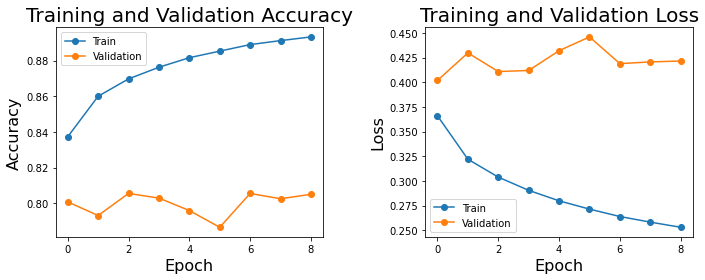

In [18]:
pcamlib.plot_history(hist_df)

This training cycle stopped after 8 epochs because the validation loss failed to decrease from the value obtained in the first epoch. There is some overfitting happening on the training set, as the training accuracy and loss diverge from the validation accuracy and loss as the number of epochs increases. This could be compensated for in the future by increasing the level of dropout between the trainable dense layers at the end of the network.

This cell makes predictions based on `y_proba` with the decision threshold set to 50% by default, but this can be adjusted by specifying a different value between 0 and 1 in the `threshold` parameter.

In [19]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 15.7 ms, sys: 5.82 ms, total: 21.5 ms
Wall time: 20.6 ms


Now that we've calculated the predictions of this model, we can evaluate it on its test accuracy, positive class recall, and AUC.

In [20]:
%%time
pcamlib.print_test_accuracy(y_true, y_pred)

0.805328369140625
CPU times: user 4.86 ms, sys: 3.85 ms, total: 8.71 ms
Wall time: 7.72 ms


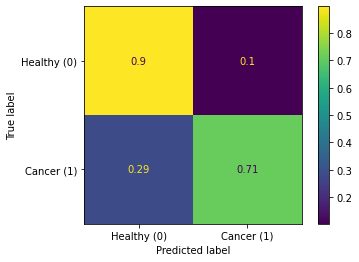

In [21]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [22]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.7576    0.8982    0.8219     16391
           1     0.8749    0.7124    0.7853     16377

    accuracy                         0.8053     32768
   macro avg     0.8162    0.8053    0.8036     32768
weighted avg     0.8162    0.8053    0.8036     32768



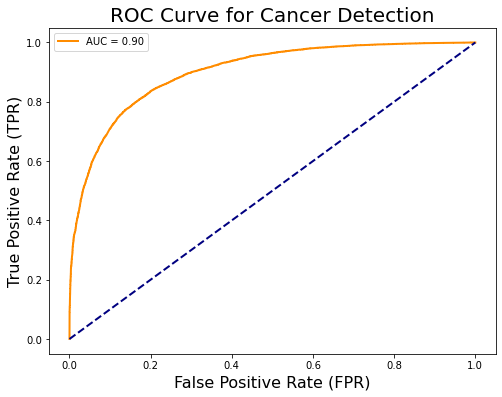

Area under curve (AUC):0.9004104998712037


In [23]:
pcamlib.plot_roc_curve(y_true, y_proba)

VGG16 achieved a test acccuracy of 80.5%, a positive class recall of 71.2%, and an AUC of 0.900.

While this model got a slightly higher test accuracy than CNN1, and a comparable AUC, the recall is significantly worse. This is still better than the pathologist benchmark, but overall I'd say this model performed worse than CNN1 because with low recall it's not necessarily well suited to prescreening histopathology samples. 

This model appears to favour predicting healthy tissue, correctly identifying around 90% of healthy tissue, but also misclassifying nearly 30% of cancer tissue as healthy.

Next, we'll see how much this model would reduce a pathologist's workload.

In [24]:
pcamlib.print_workload_reduction(y_pred)

59.3%


This model would theoretically reduce the pathologist's workload by 59.3%, however, this comes at the cost of missing nearly 30% of the cancer samples, which in my opinion would make this model unsuitable for use as a pre-screening tool.

|                     | Pathologist  | CNN1  | VGG16 |
|---------------------|--------------|-------|-------|
| AUC                 | 0.810 (mean) | 0.906 | 0.900 |
| Recall              | 62.8%        | 93.5% | 71.2% |
| Test Accuracy       | --           | 78.7% | 80.5% |
| Workload Reduced By | --           | 35.3% | 59.3% |

And finally, we can take a look at some of the misclassified images.

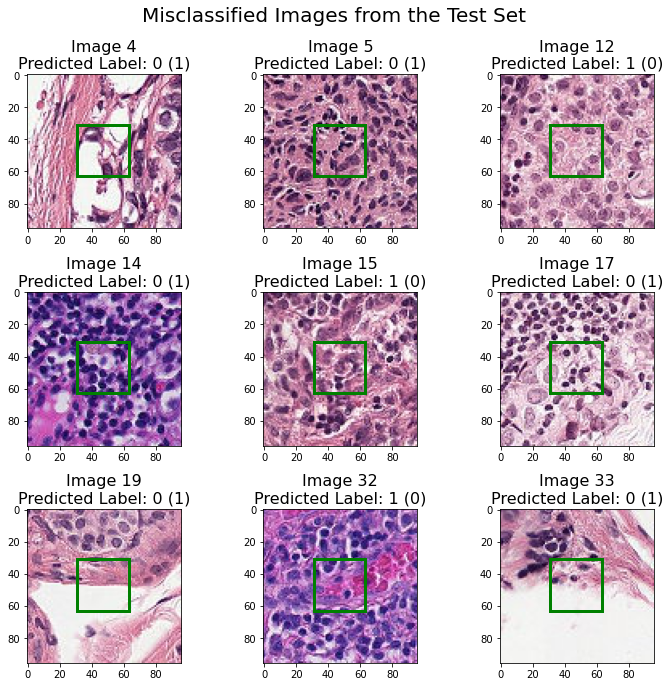

In [25]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)

I have outlined my hypotheses for misclassified images in the notebook for CNN1. However, since this model made many more incorrect predictions on the cancerous images compared to the other model which made most of its mistakes on healthy images, it's interesting to look through these images by adjusting the `image_index` parameter to see what some of these images look like.